## Economic Dispatch

Economic dispatch is a classic problem in power systems operation, where a system operator is interested in minimizing the operating costs subject to some set of physical constraints on the units. Here we use the most basic example where units have stable operating regions between their minimum power output, $p_{min}$, and their maximum power output, $p_{max}$. We also use $f_i(p_i)$ to represent the operating cost of a generating unit. The collective power output of all generating units must be capable of satisfy the total demand the system, $d$.

$$\min \sum \limits _{i} f_i(p_i)$$

$$s.t. \sum \limits _{i}p_i = d$$

$$p_{min} \le p_i \le p_{max}$$

Cost functions $f_i(p_i)$ are usually represented as quadratic functions of the form:
$$f_i(p_i) = \frac{a_i}{2}p_i^2 + b_ip_i + c_i$$

where $a_k$, $b_k$, $c_k$ are fit from data. Let's see how we can solve this using Python.

In [112]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

import warnings
warnings.filterwarnings('ignore')

## Problem Setup:
Suppose we have a system consisting of six units, with attributes described below, and a total instantaneous load of 1200 MW. For simplicity, we've set the constants $c_k$ to zero.

In [113]:
df = pd.DataFrame(
    {
        "unit": ["1", "2", "3", "4", "5", "6"],
        "pmin": [10, 10, 35, 35, 125, 130],
        "pmax": [125, 150, 210, 225, 315, 325],
        "a": [0.305, 0.212, 0.071, 0.057, 0.036, 0.042],
        "b": [35.539, 46.160, 38.308, 40.397, 38.270, 36.328],
        "c": [0, 0, 0, 0, 0, 0]
    }
)
df

,unit,pmin,pmax,a,b,c
0,1,10,125,0.305,35.539,0
1,2,10,150,0.212,46.160,0
2,3,35,210,0.071,38.308,0
3,4,35,225,0.057,40.397,0
4,5,125,315,0.036,38.270,0
5,6,130,325,0.042,36.328,0


We're interested in finding the optimal set points for each generating unit, which we designate here as the vector $p$. We also set the demand $d$ to 1,200 MW.

In [114]:
p = cvx.Variable(len(df))
d = 1200

Next we build the objective function, the constraints, and instantiate the model. Finally, we solve the problem.

In [115]:
objective = cvx.Minimize(1/2 * cvx.quad_form(p, np.diag(df.a.values)) + df.b.values * p + df.c.values)
constraints = [sum(p) >= d, p >= df.pmin.values, p <= df.pmax.values]
model = cvx.Problem(objective, constraints)
model.solve()
print('Successfully solved the economic dispatch problem!')

Successfully solved the economic dispatch problem!


In [116]:
df['dispatch'] = p.value
df['loading'] = df.dispatch / df.pmax * 100

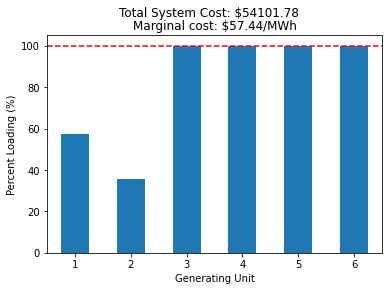

In [117]:
df.plot.bar(x='unit', y='loading', legend=None)
plt.xticks(rotation=0)
plt.xlabel("Generating Unit")
plt.ylabel("Percent Loading (%)")
plt.axhline(y=100, color='r', linestyle='--')
plt.suptitle(f'Total System Cost: ${round(objective.value, 2)}')
plt.title(f'Marginal cost: ${round(float(constraints[0].dual_value), 2)}/MWh')
plt.show()